In [6]:
import pyqg
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
matplotlib.rcParams.update({ 'font.size': 14, 'axes.formatter.limits': [-3,4] })

import subgrid_forcing_tools as sg

In [60]:
year = 24*60*60*360.
m = pyqg.QGModel(tmax=10*year, twrite=10000, tavestart=5*year)

datasets = [[],[]]
model = m
kw = dict(dims=('x','y'), coords={'x': model.x[0], 'y': model.y[:,0]})
t = 0
freq= 1
tmax = 20000
while model.t < model.tmax and t < tmax:

    
    model._step_forward()
    
    if t % freq == 0:
        for layer in range(len(model.u)):
            u = xr.DataArray(np.array(model.ufull[layer]), **kw)
            v = xr.DataArray(np.array(model.vfull[layer]), **kw)
            q = xr.DataArray(np.array(model.q[layer]), **kw)
            datasets[layer].append(xr.Dataset(data_vars=dict(
              x_velocity=u, y_velocity=v, potential_vorticity=q)))
            
    t += 1
    
time_data = xr.concat(datasets[0], 'time')

INFO:  Logger initialized
INFO: Step: 10000, Time: 7.20e+07, KE: 5.44e-04, CFL: 0.096
INFO: Step: 20000, Time: 1.44e+08, KE: 4.80e-04, CFL: 0.097


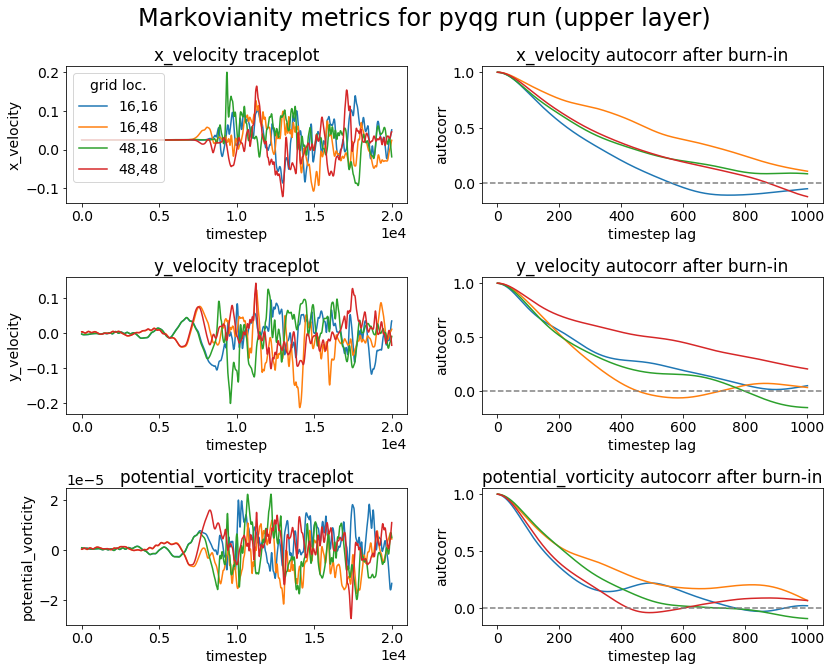

In [81]:
coords = [(16,16),(16,48),(48,16),(48,48)]
leg = False
with figure_grid(3,2) as g:
  g.title("Markovianity metrics for pyqg run (upper layer)", fontsize=24)
  for k in time_data.keys():
    g.next(title=f"{k} traceplot")
    for i,j in coords:
      plt.plot(time_data[k][:,i-1,j-1], label=f"{i},{j}")
    if not leg:
      plt.legend(loc='upper left', title='grid loc.')
      leg = True
    plt.ylabel(k)
    plt.xlabel('timestep')
    
    g.next(title=f"{k} autocorr after burn-in")
    for i,j in coords:
      plt.plot(acf(time_data[k][:,i-1,j-1][10000:], nlags=1000), label=f"{i},{j}")
    plt.axhline(0, ls='--', color='gray')
    plt.ylabel('autocorr')
    plt.xlabel('timestep lag')

In [90]:
12 * ((model.tc * 1000) / year)

7.71604938271605

In [78]:
time_data2 = xr.concat(datasets[1], 'time')

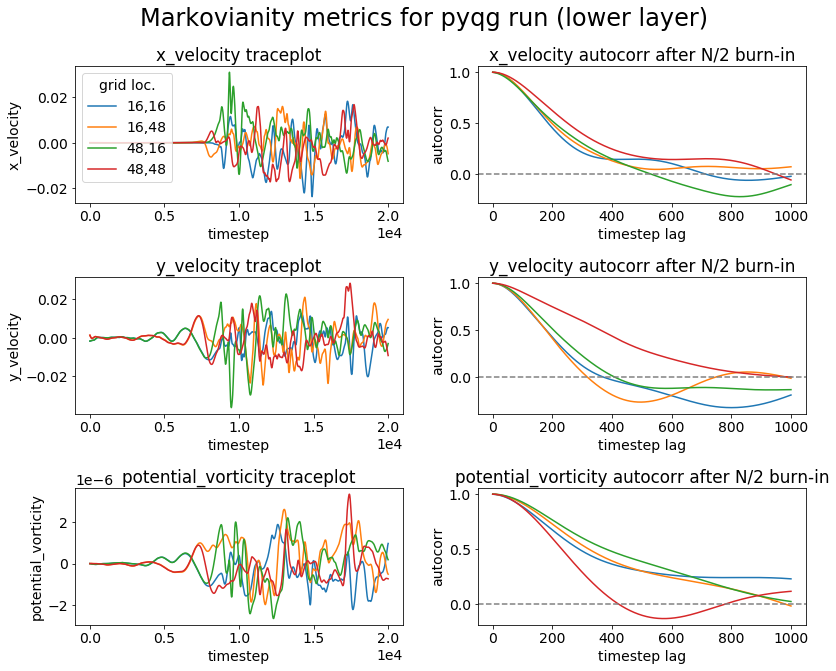

In [82]:
coords = [(16,16),(16,48),(48,16),(48,48)]
leg = False
with figure_grid(3,2) as g:
  g.title("Markovianity metrics for pyqg run (lower layer)", fontsize=24)
  for k in time_data2.keys():
    g.next(title=f"{k} traceplot")
    for i,j in coords:
      plt.plot(time_data2[k][:,i-1,j-1], label=f"{i},{j}")
    if not leg:
      plt.legend(loc='upper left', title='grid loc.')
      leg = True
    plt.ylabel(k)
    plt.xlabel('timestep')
    
    g.next(title=f"{k} autocorr after N/2 burn-in")
    for i,j in coords:
      plt.plot(acf(time_data2[k][:,i-1,j-1][10000:], nlags=1000), label=f"{i},{j}")
    plt.axhline(0, ls='--', color='gray')
    plt.ylabel('autocorr')
    plt.xlabel('timestep lag')

In [54]:
class figure_grid():
    def next_subplot(self, title=None, **kwargs):
        if self.next_title is not None:
          plt.title(self.next_title)
        self.subplots += 1
        self.next_title = title
        return self.fig.add_subplot(self.rows, self.cols, self.subplots, **kwargs)

    def each_subplot(self):
        for _ in range(self.rows * self.cols):
            yield self.next_subplot()

    def title(self, title, fontsize=16, y=1.0, **kwargs):
        self.fig.suptitle(title, y=y, fontsize=fontsize, va='bottom', **kwargs)

    def __init__(self, rows, cols, rowheight=3, rowwidth=12, after_each=lambda: None, filename=None):
        self.rows = rows
        self.cols = cols
        self.fig = plt.figure(figsize=(rowwidth, rowheight*self.rows))
        self.subplots = 0
        self.next_title = None
        self.filename = filename

    def __enter__(self):
        return self

    def __exit__(self, _type, _value, _traceback):
        if self.next_title is not None:
          plt.title(self.next_title)
        if self.filename:
            try:
                plt.tight_layout()
                plt.savefig(self.filename, bbox_inches='tight')
            except:
                print("ERROR SAVING FIGURE")
            plt.close(self.fig)
        else:
            plt.tight_layout()
            plt.show()

    next = next_subplot
